In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [114]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestClassifier
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense


In [115]:
#Read all transaction dataset
df = pd.read_csv("./data-new/transactions_obf.csv")
df

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500
...,...,...,...,...,...,...,...,...,...,...
118616,2018-01-30T23:52:16Z,103590747A1,d3c036ac,0b1dae,6300,826,NN1,81,50.91,7500
118617,2018-01-30T23:57:16Z,18903650A1,e0ad403a,e5d3c5,5812,826,TW9,5,71.00,10500
118618,2018-01-30T23:59:03Z,103582443A1,d3c036ac,0b1dae,6300,826,NN1,81,17.00,8500
118619,2018-01-31T00:04:44Z,14841868A1,ec212849,1ab20c,4812,826,SL1,1,11.00,7500


In [116]:
#Read fraud dataset
labs = pd.read_csv("./data-new/labels_obf.csv")
labels = list(labs["eventId"])


In [117]:
#Match All transaction to fraud labels to create one dataframe with labels

fraud = []

for index,row in df.iterrows():
    if row["eventId"] in labels:
        fraud.append(1)
    else:
        fraud.append(0)
        
df["Fraud"] = fraud
df

        
    


,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,Fraud
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,0
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,0
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,0
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,0
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,0
...,...,...,...,...,...,...,...,...,...,...,...
118616,2018-01-30T23:52:16Z,103590747A1,d3c036ac,0b1dae,6300,826,NN1,81,50.91,7500,0
118617,2018-01-30T23:57:16Z,18903650A1,e0ad403a,e5d3c5,5812,826,TW9,5,71.00,10500,0
118618,2018-01-30T23:59:03Z,103582443A1,d3c036ac,0b1dae,6300,826,NN1,81,17.00,8500,0
118619,2018-01-31T00:04:44Z,14841868A1,ec212849,1ab20c,4812,826,SL1,1,11.00,7500,0


In [118]:
#Find Missing values
df.isna().sum()

transactionTime          0
eventId                  0
accountNumber            0
merchantId               0
mcc                      0
merchantCountry          0
merchantZip          23005
posEntryMode             0
transactionAmount        0
availableCash            0
Fraud                    0
dtype: int64

In [119]:
#Find Duplicated Values
df.duplicated().sum()

0

In [120]:
#convert categorical columns to category type

categoricals = ["accountNumber","merchantId","mcc","merchantCountry","merchantZip","posEntryMode","Fraud"]

def convert_to_categorical(categoricals,xcolumn):
    for i in categoricals:
        xcolumn[i] = xcolumn[i].astype("category")
    return xcolumn

df = convert_to_categorical(categoricals=categoricals,xcolumn=df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118621 entries, 0 to 118620
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   transactionTime    118621 non-null  object  
 1   eventId            118621 non-null  object  
 2   accountNumber      118621 non-null  category
 3   merchantId         118621 non-null  category
 4   mcc                118621 non-null  category
 5   merchantCountry    118621 non-null  category
 6   merchantZip        95616 non-null   category
 7   posEntryMode       118621 non-null  category
 8   transactionAmount  118621 non-null  float64 
 9   availableCash      118621 non-null  int64   
 10  Fraud              118621 non-null  category
dtypes: category(7), float64(1), int64(1), object(2)
memory usage: 6.8+ MB


In [121]:
#statistical description of dataframe

df.describe(include="all")

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,Fraud
count,118621,118621,118621,118621,118621.0,118621.0,95616,118621.0,118621.000000,118621.000000,118621.0
unique,118105,118621,766,33327,361.0,82.0,3260,10.0,NaN,NaN,2.0
top,2017-09-04T23:08:44Z,101053380A1,66b2f8b3,96878e,5411.0,826.0,0,5.0,NaN,NaN,0.0
freq,3,1,1312,3294,23937.0,95616.0,14474,70228.0,NaN,NaN,117746.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.674774,6625.508974,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183.665315,3410.289486,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.150000,500.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.030000,4500.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.250000,7500.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.000000,8500.000000,NaN


In [122]:
#convert transaction time column to Datetime type 

df["transactionTime"] = pd.to_datetime(df["transactionTime"], infer_datetime_format=True)

In [123]:
#order by date time
df.sort_values(by='transactionTime', inplace=True)

In [124]:
#Calculate time between transactions
dic = {}
time_since_last_transaction = []

for index,row in df.iterrows():
    if row["accountNumber"] not in dic.keys():
        dic[row["accountNumber"]] = row["transactionTime"]
        time_since_last_transaction.append(0)
    else:
        time = (row["transactionTime"] - dic[row["accountNumber"]]).total_seconds()
        time_since_last_transaction.append(time)
        dic[row["accountNumber"]] = row["transactionTime"]
        
      

In [125]:
#Add time between transactions to dataframe
df.insert(1, "time since last transaction in seconds", time_since_last_transaction)
df

,transactionTime,time since last transaction in seconds,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,Fraud
0,2017-01-01 00:00:00,0.0,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,0
3,2017-01-01 00:15:07,0.0,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,0
4,2017-01-01 00:37:09,0.0,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,0
2,2017-01-01 00:43:17,0.0,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,0
1,2017-01-01 00:49:03,0.0,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,0
...,...,...,...,...,...,...,...,...,...,...,...,...
118620,2018-01-30 23:49:09,117993.0,14844076A1,ec212849,1ef22b,4812,826,SL1,81,11.00,7500,0
118616,2018-01-30 23:52:16,120480.0,103590747A1,d3c036ac,0b1dae,6300,826,NN1,81,50.91,7500,0
118617,2018-01-30 23:57:16,31540.0,18903650A1,e0ad403a,e5d3c5,5812,826,TW9,5,71.00,10500,0
118618,2018-01-30 23:59:03,407.0,103582443A1,d3c036ac,0b1dae,6300,826,NN1,81,17.00,8500,0


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118621 entries, 0 to 118619
Data columns (total 12 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   transactionTime                         118621 non-null  datetime64[ns]
 1   time since last transaction in seconds  118621 non-null  float64       
 2   eventId                                 118621 non-null  object        
 3   accountNumber                           118621 non-null  category      
 4   merchantId                              118621 non-null  category      
 5   mcc                                     118621 non-null  category      
 6   merchantCountry                         118621 non-null  category      
 7   merchantZip                             95616 non-null   category      
 8   posEntryMode                            118621 non-null  category      
 9   transactionAmount                    

# Data Visualisation

In [127]:
#Class distribution
df["Fraud"].value_counts()

0    117746
1       875
Name: Fraud, dtype: int64

<AxesSubplot:xlabel='Fraud', ylabel='count'>

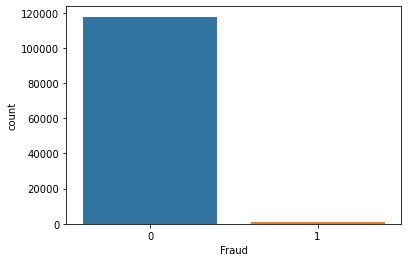

In [128]:
#Count of how many frauds or not
sns.countplot(x="Fraud",data=df)

<ipython-input-129-252388f3e615>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax = ax)


Text(0.5, 0.98, 'Histograms for full dataset numerical features')

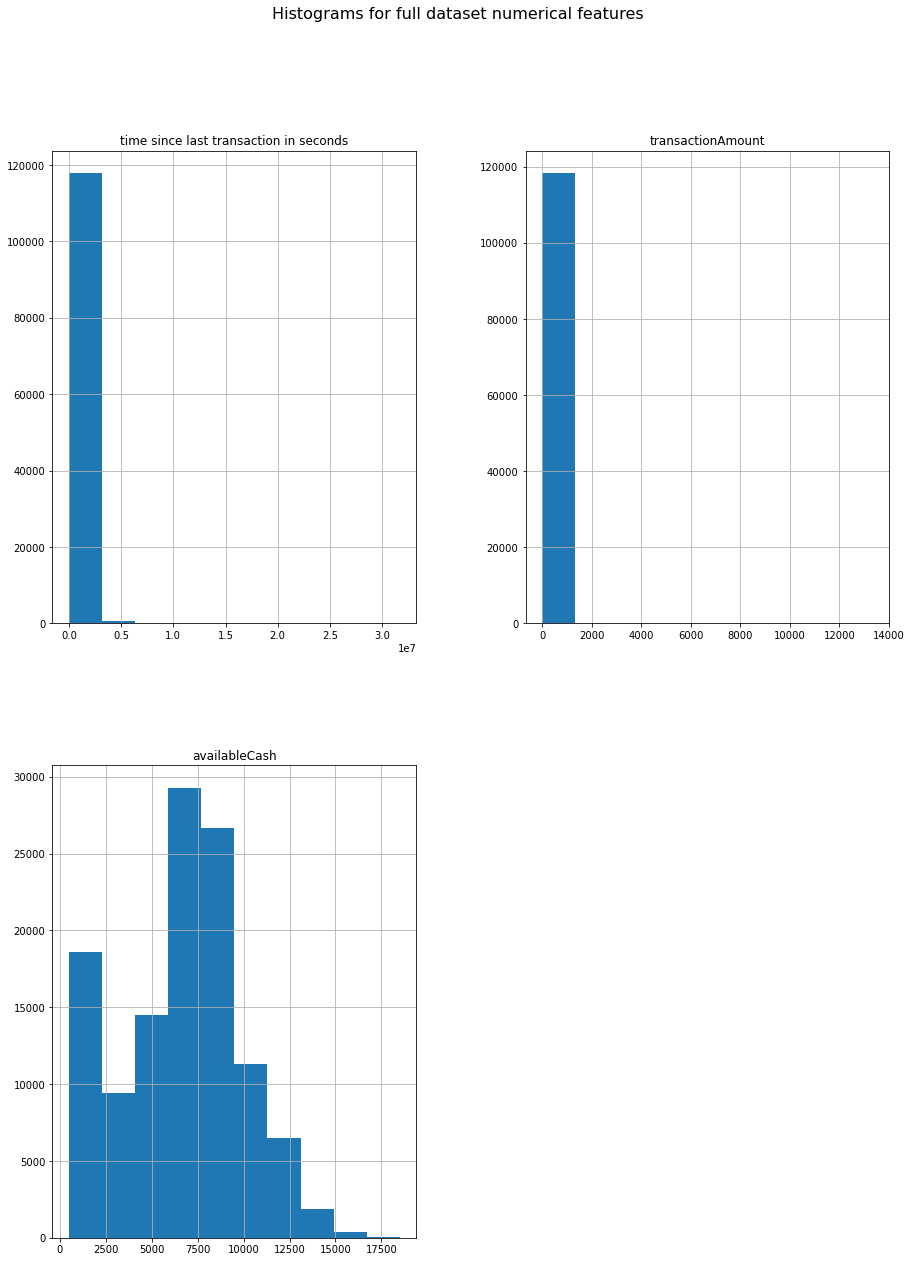

In [129]:
#Histograms for full dataset numerical features

fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax)
fig.suptitle('Histograms for full dataset numerical features',fontsize=16)

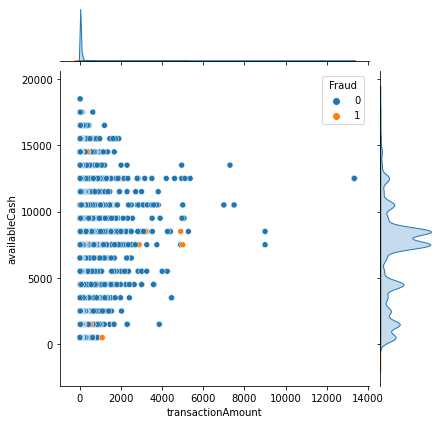

In [130]:
#Scatterplot between transactionAmount and availableCash
sns.jointplot(x='transactionAmount',y='availableCash',data=df,kind='scatter',hue="Fraud")

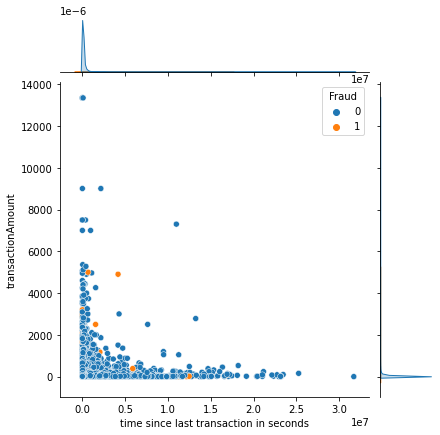

In [131]:
#Scatterplot between transactionAmount and time since last transaction in seconds
sns.jointplot(x='time since last transaction in seconds',y='transactionAmount',data=df,kind='scatter',hue="Fraud")


In [132]:
#Seperate Fraud and Non Fraud dataframe
frauds = df[df["Fraud"] == 1]
nonfrauds = df[df["Fraud"] == 0]
len(nonfrauds)

117746

In [133]:
#Obtain percetage of frauds
outlier_frac = len(frauds)/len(nonfrauds)
outlier_frac

0.007431250318482157

<ipython-input-134-56c56bd3387f>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  frauds.hist(ax = ax)


Text(0.5, 0.98, 'Histograms for Fraud numerical features')

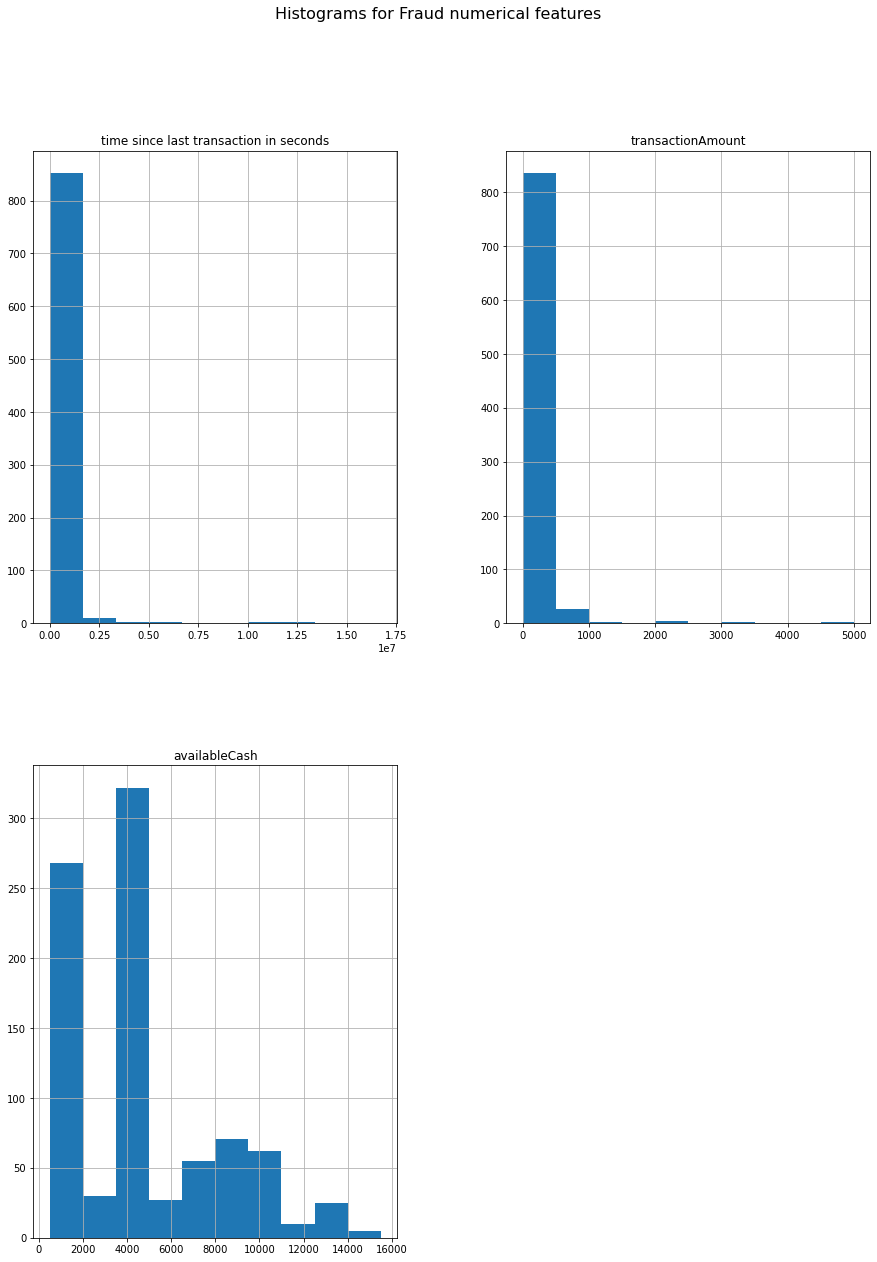

In [134]:
#Histograms for Fraud numerical features

fig = plt.figure(figsize = (15,20))
ax = fig.gca()
frauds.hist(ax = ax)
fig.suptitle('Histograms for Fraud numerical features',fontsize=16)

<ipython-input-135-91e94411657b>:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  nonfrauds.hist(ax = ax)


Text(0.5, 0.98, 'Histograms for non Fraud numerical features')

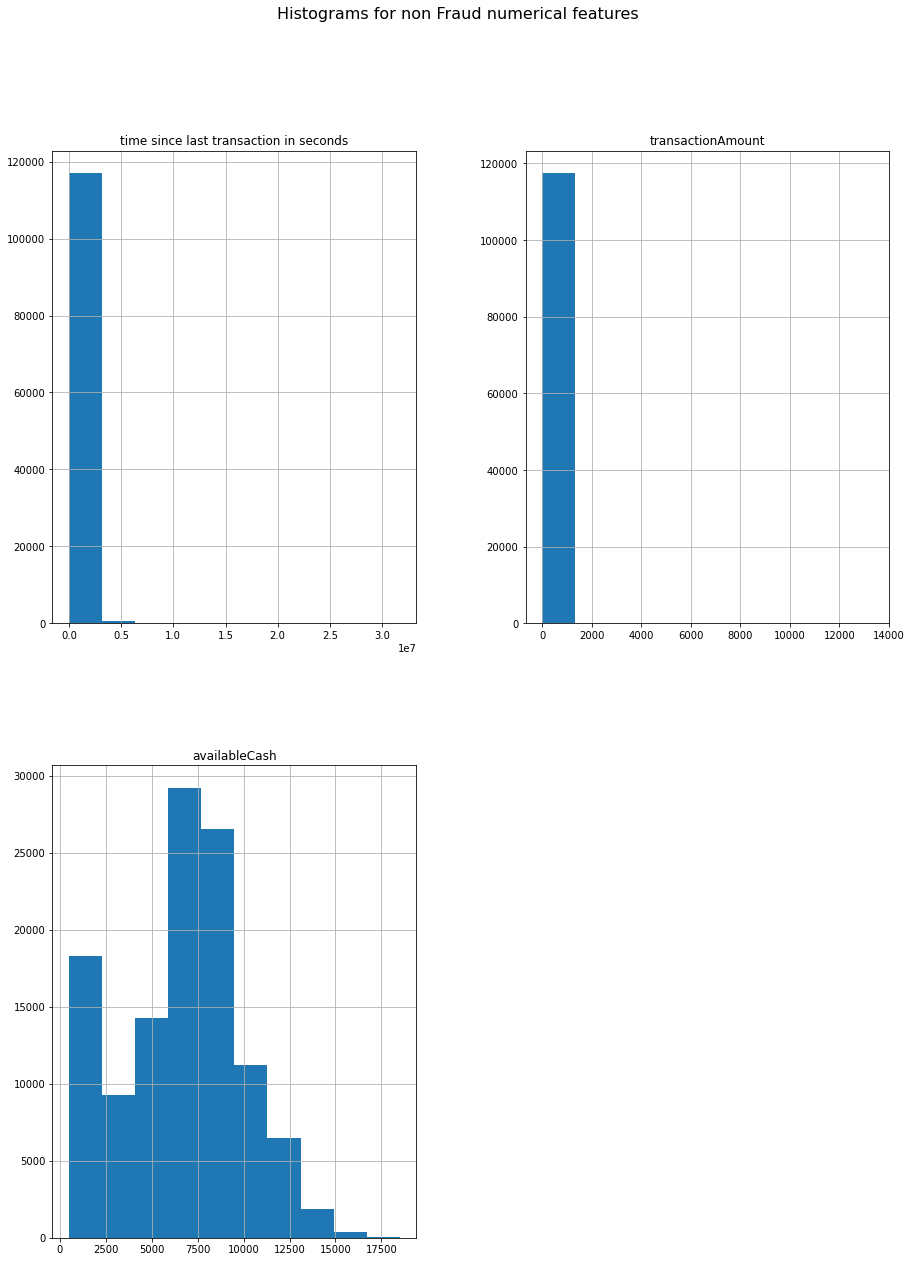

In [135]:
#Histograms for non Fraud numerical features

fig = plt.figure(figsize = (15,20))

ax = fig.gca()
nonfrauds.hist(ax = ax)
fig.suptitle('Histograms for non Fraud numerical features',fontsize=16)

In [136]:
#Function to draw boxplots of the numerical data attributes
def boxplots(ax,column,xlabel,data,title):
    sns.boxplot(x=column,data=data,ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("value")
    ax.set_title(title)

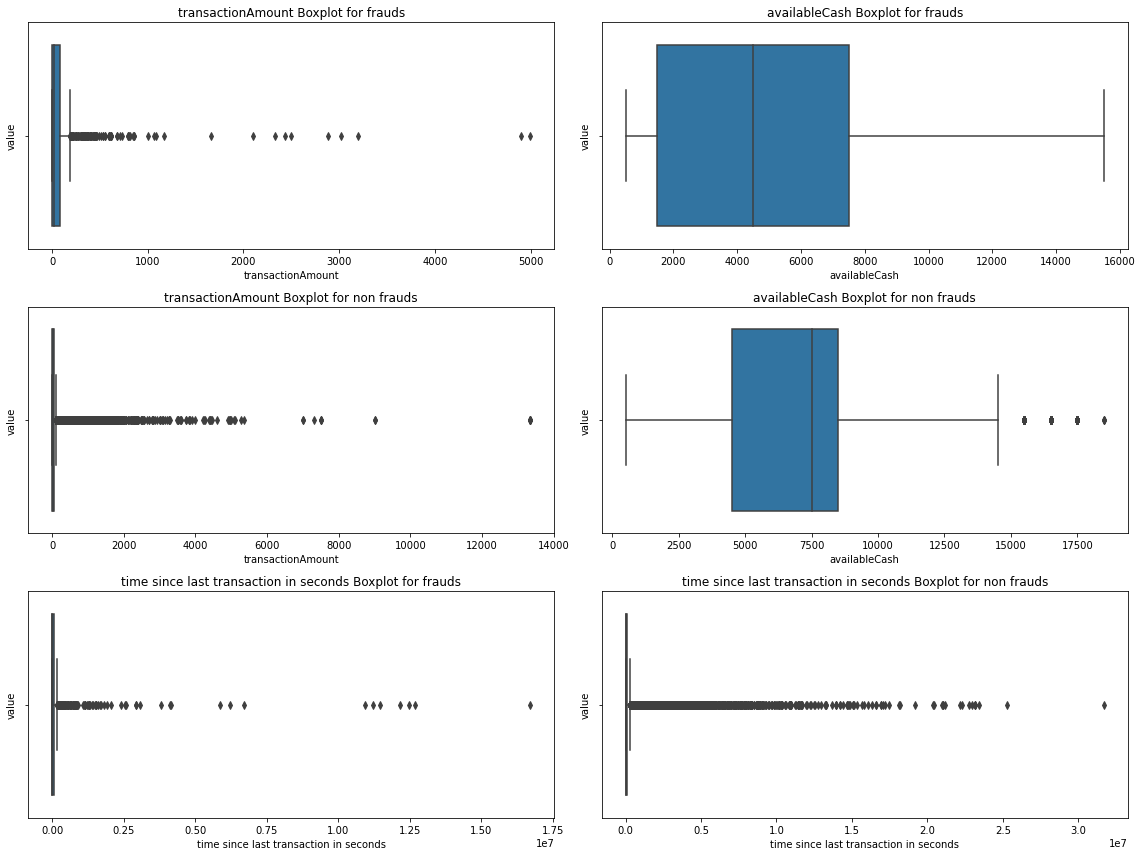

In [137]:
#Boxplots of numerical attributes
fig, ((ax0, ax1), (ax2, ax3),(ax4, ax5)) = plt.subplots(nrows=3, ncols=2,figsize=(16,12))

boxplots(ax=ax0,column="transactionAmount",xlabel="transactionAmount",data = frauds,title="transactionAmount Boxplot for frauds")
boxplots(ax=ax1,column="availableCash",xlabel="availableCash",data = frauds,title="availableCash Boxplot for frauds")
boxplots(ax=ax2,column="transactionAmount",xlabel="transactionAmount",data = nonfrauds,title="transactionAmount Boxplot for non frauds")
boxplots(ax=ax3,column="availableCash",xlabel="availableCash",data = nonfrauds,title="availableCash Boxplot for non frauds")
boxplots(ax=ax4,column="time since last transaction in seconds",xlabel="time since last transaction in seconds",data = frauds,title="time since last transaction in seconds Boxplot for frauds")
boxplots(ax=ax5,column="time since last transaction in seconds",xlabel="time since last transaction in seconds",data = nonfrauds,title="time since last transaction in seconds Boxplot for non frauds")

plt.tight_layout()

plt.show()

In [138]:
#Function to draw countplots of the categorical data attributes
def countplots(ax,column,xlabel,data,title):
    sns.countplot(x=column,data=data,ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("count")
    ax.set_title(title)

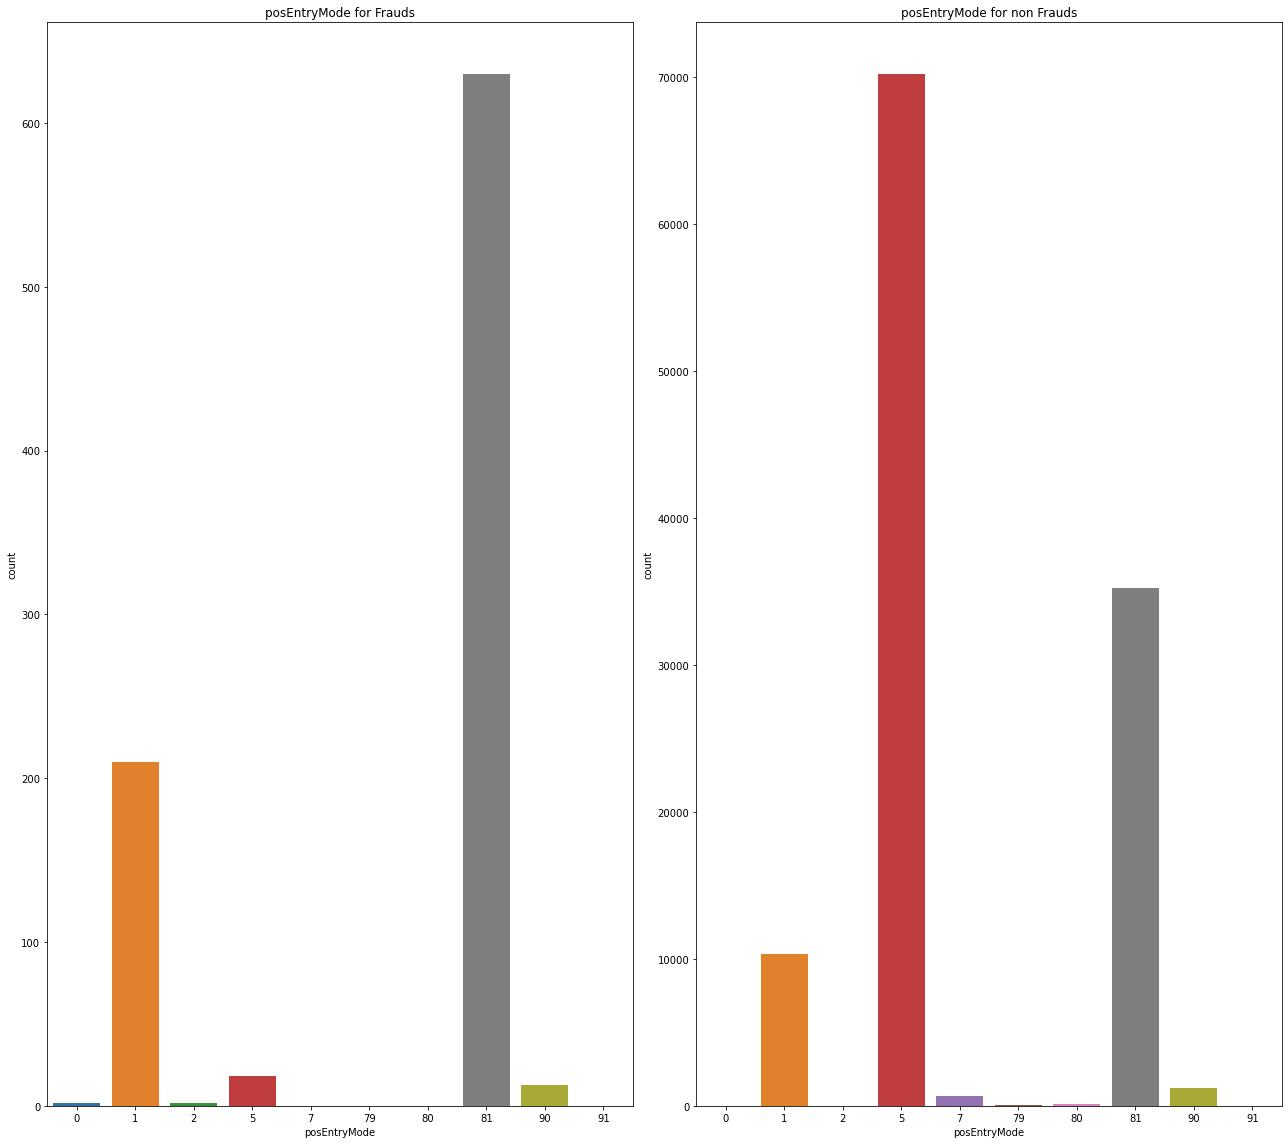

In [139]:
#Countplots of categorical columns
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2,figsize=(18,16))
    
countplots(ax=ax0,column="posEntryMode",xlabel="posEntryMode",data=frauds,title="posEntryMode for Frauds")
countplots(ax=ax1,column="posEntryMode",xlabel="posEntryMode",data=nonfrauds,title="posEntryMode for non Frauds")


plt.tight_layout()

plt.show()

In [140]:
merchant_country_frauds = (frauds["merchantCountry"].value_counts()[0:15]/frauds["merchantCountry"].count())*100
merhcant_country_frauds_index = [str(i) for i in merchant_country_frauds.index]


In [141]:
merchant_country_nonfrauds = (nonfrauds["merchantCountry"].value_counts()[0:15]/nonfrauds["merchantCountry"].count())*100
merhcant_country_nonfrauds_index = [str(i) for i in merchant_country_nonfrauds.index]

In [142]:
merchant_mcc_frauds = (frauds["mcc"].value_counts()[0:15]/frauds["mcc"].count())*100
merhcant_mcc_frauds_index = [str(i) for i in merchant_mcc_frauds.index]


In [143]:
merchant_mcc_nonfrauds = (nonfrauds["mcc"].value_counts()[0:15]/nonfrauds["mcc"].count())*100
merhcant_mcc_nonfrauds_index = [str(i) for i in merchant_mcc_nonfrauds.index]

In [144]:
accountno_frauds = (frauds["accountNumber"].value_counts()[0:15]/frauds["accountNumber"].count())*100
accountno_frauds_index = [str(i) for i in accountno_frauds.index]

In [145]:
accountno_nonfrauds = (nonfrauds["accountNumber"].value_counts()[0:15]/nonfrauds["accountNumber"].count())*100
accountno_nonfrauds_index = [str(i) for i in accountno_nonfrauds.index]

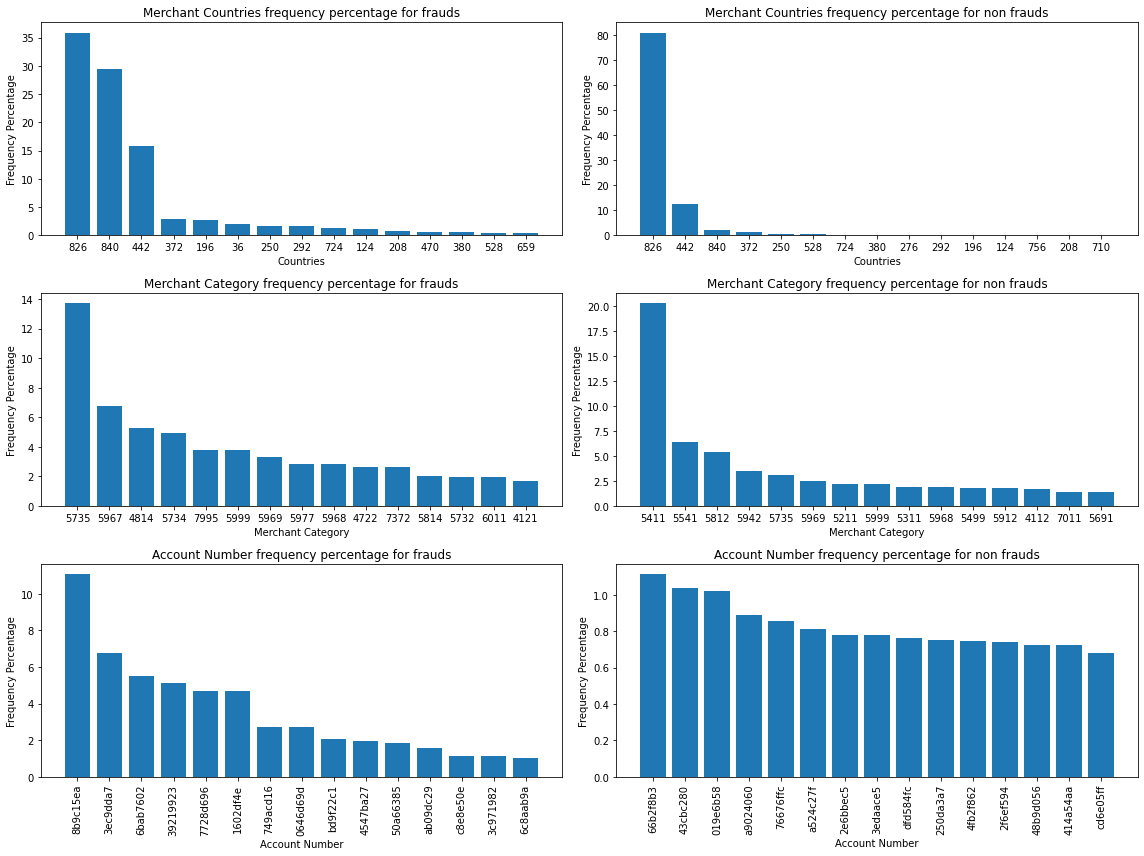

In [146]:
#10 most frequently seen merchant countries, categories and account numbers between Fraud and Non Fraud datasets
fig, ((ax0, ax1), (ax2, ax3),(ax4, ax5)) = plt.subplots(nrows=3, ncols=2,figsize=(16,12))

ax0.bar(merhcant_country_frauds_index, merchant_country_frauds.values)
ax0.set_xlabel("Countries")
ax0.set_ylabel("Frequency Percentage")
ax0.set_title("Merchant Countries frequency percentage for frauds")

ax1.bar(merhcant_country_nonfrauds_index, merchant_country_nonfrauds.values)
ax1.set_xlabel("Countries")
ax1.set_ylabel("Frequency Percentage")
ax1.set_title("Merchant Countries frequency percentage for non frauds")

ax2.bar(merhcant_mcc_frauds_index, merchant_mcc_frauds.values)
ax2.set_xlabel("Merchant Category")
ax2.set_ylabel("Frequency Percentage")
ax2.set_title("Merchant Category frequency percentage for frauds")

ax3.bar(merhcant_mcc_nonfrauds_index, merchant_mcc_nonfrauds.values)
ax3.set_xlabel("Merchant Category")
ax3.set_ylabel("Frequency Percentage")
ax3.set_title("Merchant Category frequency percentage for non frauds")

ax4.bar(accountno_frauds_index, accountno_frauds.values)
ax4.set_xlabel("Account Number")
ax4.tick_params(axis='x', rotation=90)
ax4.set_ylabel("Frequency Percentage")
ax4.set_title("Account Number frequency percentage for frauds")

ax5.bar(accountno_nonfrauds_index, accountno_nonfrauds.values)
ax5.set_xlabel("Account Number")
ax5.tick_params(axis='x', rotation=90)
ax5.set_ylabel("Frequency Percentage")
ax5.set_title("Account Number frequency percentage for non frauds")

fig.tight_layout() 